In [1]:
import os
import sys
import numpy as np

from data.toy_data import generate_2d_data
from data.plot_samples import plot_samples_2d
from data.visu_density import plot_heatmap_2d
from normalizingflows.flow_catalog import NeuralSplineFlow
from utils.train_utils import shuffle_split, train_density_no_tf
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
import time
from utils.train_utils import sanity_check


tensorflow:  2.1.0
tensorflow-probability:  0.9.0


### Fetch the data and the related spesifications

In [2]:
dataset = "2spirals"
batch_size = 2000
max_epochs = 10000
layers = 8
shape = [32, 32]
train_split = 0.8
val_split = 0.1
samples, intervals = generate_2d_data(dataset, batch_size=batch_size)
train_data, val_data, test_data = shuffle_split(samples, train_split, val_split)
train_data = tf.data.Dataset.from_tensor_slices(train_data)
batched_train_data = train_data.batch(400)

### see the data

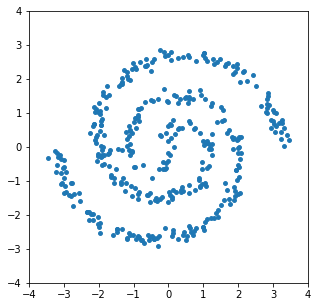

In [19]:
plot_samples_2d(next(iter(batched_train_data)))

In [11]:
# base distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))
# create a normalizing flow
bijectors = []

bijector_chain = []
for i in range(layers):
    bijector_chain.append(NeuralSplineFlow(input_dim=2, d_dim=2, number_of_bins=32, nn_layers = shape, b_interval= [2, 2]))
    bijector_chain.append(tfp.bijectors.Permute([1, 0]))


bijector = tfb.Chain(bijectors=list(reversed(bijector_chain)), name='chain_of_real_nvp')

flow = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)

### Train the flow

In [24]:
checkpoint_directory = "{}/tmp_{}_{}_{}".format(dataset, layers, shape[0], base_lr)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=flow)

global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta = 0  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_no_tf(flow, optimizer, batch)

    if i % int(100) == 0:
        val_loss = -tf.reduce_mean(flow.log_prob(val_data))
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        elif val_loss > (min_val_loss + delta):
            break

train_time = time.time() - t_start



0, train_loss: 8.860601425170898, val_loss: 8.754384994506836


KeyboardInterrupt: 

### Evaluate

In [ ]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()
test_loss = -tf.reduce_mean(flow.log_prob(test_data))
test_time = time.time() - t_start

# save density estimation of best model
save_dir = "{}/{}_density_{}_{}_{}_{}_{}".format(dataset, dataset, batch_size, layers, shape, base_lr, "asd")
plot_heatmap_2d(flow, -4.0, 4.0, -4.0, 4.0, name=save_dir)

save_dir = "{}/{}_sampling_{}_{}_{}_{}_{}".format(dataset, dataset, batch_size, layers, shape, base_lr, "min_val_epoch")
plot_samples_2d(flow.sample(1000), name=save_dir)

# remove checkpoint
filelist = [f for f in os.listdir(checkpoint_directory)]
for f in filelist:
    os.remove(os.path.join(checkpoint_directory, f))
os.removedirs(checkpoint_directory)

print(f'Test loss: {test_loss} at epoch: {i}')
print(f'Min val loss: {min_val_loss} at epoch: {min_val_epoch}')
print(f'Last val loss: {val_loss} at epoch: {i}')
print(f'Min train loss: {min_train_loss} at epoch: {min_train_epoch}')
print(f'Last val loss: {train_loss} at epoch: {i}')
print(f'Training time: {train_time}')
print(f'Test time: {test_time}')

results = {
    'test_loss': float(test_loss),
    'min_val_loss': float(min_val_loss),
    'min_val_epoch': min_val_epoch,
    'val_loss': float(val_loss),
    'min_train_loss': float(min_train_loss),
    'min_train_epoch': min_train_epoch,
    'train_loss': float(train_loss),
    'train_time': train_time,
    'test_time': test_time,
    'trained_epochs': i,
    'trainable variables': n_trainable_variables,
}


### See the density function

In [ ]:
plot_heatmap_2d(flow, mesh_count=100)